In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Dense, Dropout, Flatten, Input, Activation, LSTM, GRU, SimpleRNN, Concatenate, TimeDistributed
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [ ]:
def get_split_datasets(data_dir, test_size=0.15, random_state=11):
    all_names = [f.stem.split("_")[0] for f in Path(f"{data_dir}").iterdir()]
    files = set(all_names)
    names = list(files)
    labels = np.zeros(len(names))

    train_names, test_names, y_train, y_test = train_test_split(
        names, labels, test_size=test_size,
        random_state=random_state)
    return train_names, test_names

def get_data_by_name(video_name, data_dir):
    return np.load(f"{data_dir}/{video_name}.npy", allow_pickle=True)

def get_data_instance(video_name, labels, data_dir, is_augmented=True, is_kinect = True):
    if is_augmented:
        data = []
        labels = []
        audmented_names = [p.stem for p in Path(f"{data_dir}").iterdir() if video_name == p.stem.split("_")[0]]
        for n in audmented_names:
            if is_kinect:
                d = get_data_by_name(video_name+"_kinect", data_dir)
            else:
                d = get_data_by_name(video_name, data_dir)
            data.append(d[0])
            labels.append(d[1])
        data = np.array(data)
        labels = np.array(labels)
    else:
        if is_kinect:
            d = get_data_by_name(video_name+"_kinect", data_dir)
        else:
            d = get_data_by_name(video_name, data_dir)
        data = np.array([d[0]])
        labels = d[1]
    return data, labels

data_dir = "kinect_input_data"
is_kinect = True
labels = "scores.csv"
train_names, test_names = get_split_datasets(data_dir)

#Get validation set names
validation_split = 0.1
slice_indx = int(len(train_names) - len(train_names)*validation_split)
validation_names = train_names[slice_indx:]
train_names = train_names[:slice_indx]

# Get data
train_features = []
train_labels = []

test_features = []
test_labels = []

val_features = []
val_labels = []

for name in train_names:
    data, labels = get_data_instance(name, labels, data_dir, True, is_kinect)
    for i in range(data.shape[0]):
        train_features.append(data[i])
    for i in range(labels.shape[0]):
        train_labels.append(labels[i])

train_features = np.array(train_features)
train_labels = np.array(train_labels)

for name in test_names:
    data, labels = get_data_instance(name, labels, data_dir, False, is_kinect)
    for i in range(data.shape[0]):
        test_features.append(data[i])
    test_labels.append(labels)

test_features = np.array(test_features)
test_labels = np.array(test_labels)

for name in validation_names:
    data, labels = get_data_instance(name, labels, data_dir, True, is_kinect)
    for i in range(data.shape[0]):
        val_features.append(data[i])
    for i in range(labels.shape[0]):
        val_labels.append(labels[i])

val_features = np.array(val_features)
val_labels = np.array(val_labels)

# Scale data

#Features
scalers = {}
for i in range(train_features.shape[1]):
    scalers[i] = StandardScaler()
    train_features[:, i, :] = scalers[i].fit_transform(train_features[:, i, :])

for i in range(train_features.shape[1]):
    train_features[:, i, :] = scalers[i].transform(train_features[:, i, :])

for i in range(val_features.shape[1]):
    val_features[:, i, :] = scalers[i].transform(val_features[:, i, :])

for i in range(val_features.shape[1]):
    val_features[:, i, :] = scalers[i].transform(val_features[:, i, :])

for i in range(test_features.shape[1]):
    test_features[:, i, :] = scalers[i].transform(test_features[:, i, :])

for i in range(test_features.shape[1]):
    test_features[:, i, :] = scalers[i].transform(test_features[:, i, :])

#Labels
scaler = StandardScaler()
train_labels = scaler.fit_transform(train_labels)
val_labels = scaler.transform(val_labels)
test_labels = scaler.transform(test_labels)

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_21 (GRU)                 (None, 20, 64)            19968     
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 20, 8)             1544      
_________________________________________________________________
max_pooling1d_43 (MaxPooling (None, 6, 8)              0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 6, 8)              136       
_________________________________________________________________
max_pooling1d_44 (MaxPooling (None, 3, 8)              0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 24)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 512)             

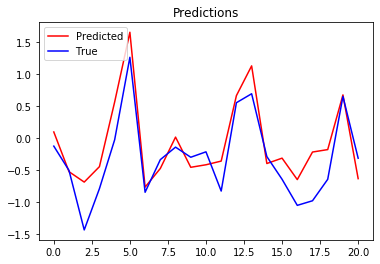

In [ ]:
def make_model():
    model = Sequential()
    model.add(GRU(64, input_shape=train_features.shape[1:], return_sequences=True))
    model.add(Conv1D(8, (3), padding="same", activation="relu"))
    model.add(MaxPooling1D(3))
    model.add(Conv1D(8, (2), padding="same", activation="relu"))
    model.add(MaxPooling1D(2))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    return model

model = make_model()
model.summary()
model.compile(loss='mean_squared_error', optimizer = Adam(3e-4))
es = EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True)
model.fit(train_features, train_labels, batch_size=16, epochs=500, callbacks = [es], verbose=1, validation_data=(val_features, val_labels))
baseline_results = model.evaluate(test_features, test_labels)

predicted = model.predict(test_features, batch_size=16)

plt.plot(predicted, '-r', label='Predicted')
plt.plot(test_labels, '-b', label='True')
plt.legend(loc="upper left")
plt.title('Predictions')
plt.show()

Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_50 (GRU)                 (None, 20, 64)            19968     
_________________________________________________________________
gru_51 (GRU)                 (None, 20, 32)            9312      
_________________________________________________________________
gru_52 (GRU)                 (None, 20, 8)             984       
_________________________________________________________________
flatten_60 (Flatten)         (None, 160)               0         
_________________________________________________________________
dense_125 (Dense)            (None, 1)                 161       
Total params: 30,425
Trainable params: 30,425
Non-trainable params: 0
_________________________________________________________________
Train on 824 samples, validate on 96 samples
Epoch 1/60
824/824 [==============================] - 24s 29ms/sample 

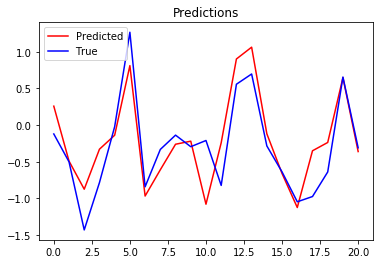

In [ ]:
def make_model2():
    model = Sequential()
    model.add(Input(shape=train_features.shape[1:]))
    model.add(GRU(64, return_sequences=True))
    model.add(GRU(32, return_sequences=True))
    model.add(GRU(8, return_sequences=True))
    model.add(Flatten())
    model.add(Dense(1))
    return model

model2 = make_model2()
model2.summary()
model2.compile(loss='mean_squared_error', optimizer = Adam(3e-4))
es = EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True)
model2.fit(train_features, train_labels, batch_size=8, epochs=60, callbacks = [es], verbose=1, validation_data=(val_features, val_labels))
baseline_results2 = model2.evaluate(test_features, test_labels)

predicted2 = model2.predict(test_features, batch_size=8)

plt.plot(predicted2, '-r', label='Predicted')
plt.plot(test_labels, '-b', label='True')
plt.legend(loc="upper left")
plt.title('Predictions')
plt.show()